In [2]:
# imports
# -------

# imports
# -------
import numpy as np
import random
import copy
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time
import multiprocessing
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import os
from os import listdir
from os.path import isfile, join
from PIL import Image
import scipy.misc
from scipy.ndimage import label



# torch related imports
# ---------------------
import torch
from torch.autograd import Variable
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision.utils import save_image
import torch.optim as optim

# neccessary imports for imgaug
# ------------------------------
import imgaug as ia
from imgaug import augmenters as iaa


%matplotlib inline
%env JOBLIB_TEMP_FOLDER=/tmp

# printing platform info
# ----------------------
import platform
print(platform.python_version())

env: JOBLIB_TEMP_FOLDER=/tmp
3.6.9


In [3]:
# printing torch
# -------------
torch.cuda.is_available()

True

In [4]:
# colab related imports & mounting drive
# --------------------------------------
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
#!unzip '/content/drive/My Drive/datasets/bdd100k.zip' -d '/content/drive/My Drive/datasets/'
#!rm -rf '/content/drive/My Drive/datasets/bdd100k.zip'

# code

### 1. helper functions

In [6]:
# GENERIC function to calculate conv outsize
# -------------------------------------------- 
def outsize_conv(n_H,n_W,f,s,pad):
    
    h = ((n_H - f + (2*pad))/s) + 1
    w = ((n_W - f + (2*pad))/s) + 1
    return h,w
    
    
# GENERIC function to calculate upconv outsize
# --------------------------------------------    
def outsize_upconv(h,w,f,s,p):
    hout = (h-1)*s - 2*p + f
    wout = (w-1)*s - 2*p + f
    return hout, wout



# GENERIC - initialises weights for a NN
# --------------------------------------
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
        
# GENERIC - change an torch image to numpy image
# ----------------------------------------------
def to_numpy_image(xin):
    
    try:
        xin = xin.data.numpy()
    except:
        xin = xin.numpy()
    
    xout = np.swapaxes(xin,1,2)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped numpy images
    # ---------------------------------
    return xout       



# GENERIC - converts numpy images to torch tensors for training
# -------------------------------------------------------------
def setup_image_tensor(xin):
    xout = np.swapaxes(xin,1,3)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped torch tensor
    # ---------------------------------
    xout = torch.from_numpy(xout)
    return xout.float()

In [7]:
# GENERIC - change an torch image to numpy image
# ----------------------------------------------
def to_numpy_image(xin):
    
    try:
        xin = xin.data.numpy()
    except:
        xin = xin.numpy()
    
    xout = np.swapaxes(xin,1,2)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped numpy images
    # ---------------------------------
    return xout       



# GENERIC - converts numpy images to torch tensors for training
# -------------------------------------------------------------
def setup_image_tensor(xin):
    xout = np.swapaxes(xin,1,3)
    xout = np.swapaxes(xout,2,3)
    
    # returns axes swapped torch tensor
    # ---------------------------------
    xout = torch.from_numpy(xout)
    return xout.float()


In [8]:
# MAIN ON THE GO STANDARD IMGAUG CODE
# -----------------------------------
def imgaug_onthego_std(x_in):

    '''

    factors to generalise across

    1. colour -- grayscale
    2. scale -- aug.perspectivescale
    3. perspective -- aug.perspectivescale
    4. variations in core shape -- aug.elastic_transformation
    5. finding objects within complex structures e.g., bird inside text -- aug.BlendAlphaRegularGrid
    6. partial structures / occlusion -- aug.coarsedropout

    '''

    # 0. initialisations
    # ------------------
    # none for now
    
    
    # 1. setting the augmentation pipeline
    # ------------------------------------
    seq = iaa.Sequential([
                          
        iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),
        iaa.CoarseDropout(0.1, size_percent=0.1, per_channel=True)

    ])
    
    
    # 2. main augmentation step
    # -------------------------
    image_aug= seq(images=x_in.astype('uint8'))
    
    # 3. final return
    # ---------------
    return image_aug


In [9]:
# function to convert a SINGLE labels map into a target map with number_channels = c
# ----------------------------------------------------------------------------------

def labels_to_maps(l_in, mx_classes):
    
    # 0. inits
    # --------
    list_of_classes = list(range(mx_classes))
    out = np.zeros((l_in.shape[0],l_in.shape[1],mx_classes))
    
    # 1. simple iter
    # --------------
    for each_class in list_of_classes:
        out[:,:,each_class] = (l_in[:,:,0]==each_class) + out[:,:,each_class]
    
    # 2.return
    # -------
    return out
        
    

In [10]:
# function to return color map
# ----------------------------

def return_colormap(x):
    
    '''
    
    1. x is in form (m,h,w,no_channels) - numpy array
    2. returns (m,h,w,1) - with index positions
    3. returns color maps based on index positions
    
    '''
    
    # 0. main color code legend here
    # https://www.rapidtables.com/web/color/RGB_Color.html
    # ------------------------------
    color_legend = {}
    color_legend[0] = np.array([255,0,0]) # red
    color_legend[1] = np.array([0,255,0]) # lime
    color_legend[2] = np.array([0,0,255]) # blue
    color_legend[3] = np.array([255,255,0]) # yellow
    color_legend[4] = np.array([0,255,255]) # cyan/aqua
    color_legend[5] = np.array([255,0,255]) # magenta
    color_legend[6] = np.array([192,192,192]) # silver
    color_legend[7] = np.array([255,0,0]) # olive
    color_legend[8] = np.array([0,128,0]) # green
    color_legend[9] = np.array([128,0,128]) # purple
    color_legend[10] = np.array([0,128,128]) # teal
    color_legend[11] = np.array([0,0,128]) # navy
    color_legend[12] = np.array([255,140,0]) # orange
    color_legend[13] = np.array([143,188,143]) # dark sea green
    color_legend[14] = np.array([70,130,180]) # steel blue
    color_legend[15] = np.array([255,20,147]) # pink
    color_legend[16] = np.array([245,222,179]) # wheat
    color_legend[17] = np.array([139,69,19]) # brown
    color_legend[18] = np.array([210,105,30]) # chocolate
    color_legend[19] = np.array([255,250,240]) # floral white
    color_legend[20] = np.array([105,105,105]) # dark gray
    color_legend[21] = np.array([105,105,105]) # dark gray
    color_legend[22] = np.array([105,105,105]) # dark gray
    color_legend[23] = np.array([105,105,105]) # dark gray
    
    # 1. inits
    # --------
    out = np.zeros((x.shape[0],x.shape[1],x.shape[2],3))
    
    # 2. max
    # ------
    max_out = np.argmax(x,3)    
    
    # 3. iter over each key of legend and assign values
    # -------------------------------------------------
    for keys in color_legend:
        
        # j = ((m==2).reshape(2,3,2,1) * np.array([8,8,8])) + j
        # -----------------------------------------------------
        out += (max_out == keys).reshape(max_out.shape[0], max_out.shape[1], max_out.shape[2], 1) * color_legend[keys]
    
    
    # 4. return
    # ---------
    return out.astype('uint8')
        


In [11]:
# main function to work out precisin, recall and f1 scores
# --------------------------------------------------------

def precision_recall_f1_accuracy(pin,yin,threshold):
    
    '''
    
    1. takes in p as numpy and y as numpy in shape (m,h,w,no_classes)
    2. also takes in labels_dict & other params - if available
    2. works out precision, recall & f1 score for all labels
    
    '''
    
    # 0. initialisations
    # ------------------
    d = {}
    y = copy.deepcopy(yin)
    no_classes = yin.shape[3]
    p = (pin >= threshold).astype(float)
    
        
    # 1. accuracy general
    # -------------------
    true_value = (p == y)
    true_value = true_value.reshape(true_value.shape[0],-1)
    to_sum = pin.shape[1] * pin.shape[2] * pin.shape[3]
    true_value_sum = np.sum(true_value, axis = 1)
    accuracy = np.mean(true_value_sum/to_sum)
    print('Basic accuracy: ' + str(accuracy))
        
        
    # 1. itering
    # ----------
    for keys in range(no_classes):
        
        # output dict initialisations
        # ---------------------------
        d[keys] = {}
        d[keys]['label'] = str(keys)
        
        # precision work out
        # ------------------
        true_curr_label = np.sum(p[:,:,:,keys]*y[:,:,:,keys])
        all_pred_curr_label = np.sum(p[:,:,:,keys])
        curr_precision = true_curr_label/(all_pred_curr_label + 0.0001)
        
        # recall work out
        # ---------------
        all_actual_curr_label = np.sum(y[:,:,:,keys])
        curr_recall = true_curr_label/(all_actual_curr_label + 0.0001)
        
        # f1 score workout
        # ----------------
        curr_f1 = 2 * ((curr_precision * curr_recall)/(curr_precision + curr_recall + 0.0001))
        
        # saving to dict
        # --------------
        d[keys]['precision'] = round(curr_precision,2)
        d[keys]['recall'] = round(curr_recall,2)
        d[keys]['f1'] = round(curr_f1,2)
        
        

    # final printing
    # --------------
    print('\nPrecision, recall and f1 scores: \n********************************\n')
    
    for keys in d:
        print('Label: ' + str(d[keys]['label']))
        print('------------')
        print('Precision: ' + str(d[keys]['precision']))
        print('Recall: ' + str(d[keys]['recall']))
        print('F1 Score: ' + str(d[keys]['f1']))
        print('\n')


In [12]:
# pooled function to build dataset
# --------------------------------

def create_trainset_pool(base_folder, h_in, w_in, master_number_classes_in, mb_size, dataset_mode, print_status_in):
    
    # need code to create triplets of arrays for fixed size given an input folder
    # ---------------------------------------------------------------------------
    
    # 0. inits
    # --------
    global print_status
    print_status = print_status_in
    
    global counter
    counter = 0
    
    global base_folder_in
    base_folder_in = base_folder

    global images_folder
    images_folder = base_folder + 'images/' + dataset_mode + '/'

    global color_folder
    color_folder = base_folder + 'color_labels/' + dataset_mode + '/'

    global labels_folder
    labels_folder = base_folder + 'labels/' + dataset_mode + '/'

    global r_h, r_w
    r_h, r_w = h_in, w_in

    global master_number_classes
    master_number_classes = master_number_classes_in

    # 1. getting list of training images from folder
    # always of extension jpg/jpeg
    # -----------------------------------------------
    global image_list
    image_list = [f for f in listdir(images_folder) if isfile(join(images_folder, f)) and '.jpg' in f.lower()]
    image_list = random.sample(image_list, mb_size)

    # initialising outputs
    # --------------------
    global x_input
    x_input = np.zeros((len(image_list), r_h, r_w, 3))
    
    global x_labels
    x_labels = np.zeros((len(image_list), r_h, r_w, 3))

    global x_target
    x_target = np.zeros((len(image_list), r_h, r_w, master_number_classes))

    global x_colormaps
    x_colormaps = np.zeros((len(image_list), r_h, r_w, 3))
    

    # 2. calling pooled functino
    # --------------------------
    pool = ThreadPool(5) 
    pool.map(create_trainset_single, list(range(len(image_list))))
    if print_status == True:
        print('Done. access at global x_input, x_target, x_labels & x_colormaps.')
    
    # closing pools
    # -------------
    pool.terminate()
    pool.join()
    

    
    
# single function
# ---------------
def create_trainset_single(i):
    
    # 0. global inits
    # ---------------
    global base_folder_in
    global images_folder
    global color_folder
    global r_h, r_w
    global master_number_classes
    global image_list
    global x_input
    global x_target
    global x_colormaps
    global counter
    global x_labels
    global print_status
    
    
    # 2. this is pooled function
    # --------------------------

    # 1. getting all images
    # ---------------------
    curr_name = image_list[i]
    curr_image = cv2.resize(cv2.cvtColor(cv2.imread(images_folder + curr_name), cv2.COLOR_BGR2RGB), (r_w, r_h), interpolation = cv2.INTER_NEAREST)
    curr_label = cv2.resize(cv2.cvtColor(cv2.imread(labels_folder + curr_name.replace('.jpg', '_train_id.png')), cv2.COLOR_BGR2RGB), (r_w, r_h), interpolation = cv2.INTER_NEAREST)
    curr_col_label = cv2.resize(cv2.cvtColor(cv2.imread(color_folder + curr_name.replace('.jpg', '_train_color.png')), cv2.COLOR_BGR2RGB), (r_w, r_h), interpolation = cv2.INTER_NEAREST)



    # 2. all images have been checked and are good so far
    # curr_label can be sliced to just one channel since teh labels are
    # really just a repeat
    # converting label to (h,w,no_channels) type
    # checked with np.all() - evaluates to true - so far good
    # -------------------------------------------------------------------
    curr_target_label_map = labels_to_maps(curr_label, master_number_classes)


    # 3. assign to global final arrays - thats it
    # -------------------------------------------
    x_input[i] = curr_image
    x_target[i] = curr_target_label_map
    x_colormaps[i] = curr_col_label
    x_labels[i] = curr_label
    counter += 1 
    
    # sanity
    # ------
    if print_status == True:
        print('done with ' + str(counter) + ' of around ' + str(len(image_list)) + ' images...', end='\r')
    


### 2. model related codes

In [13]:
# a function to load a saved model
# --------------------------------

def load_saved_model_function_cpu(path):
    
    
    ''' path = /folder1/folder2/model_ae.tar format'''
    
    # 1. loading full model
    # ---------------------
    model = torch.load(path.replace('.tar','_MODEL.tar'))
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))
    
    # 2. Applying state dict
    # loads to CPU
    # torch.load(checkpoint_file, map_location=‘cpu’)
    # ------------------------------------------------
    checkpoint = torch.load(path, map_location='cpu')
    
    # loading checkpoint
    # -------------------
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # loading optimizer
    # -----------------
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    
    # loading other stuff
    # -------------------
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    loss_mode = checkpoint['loss_mode']
    
    # just return model only
    # ----------------------
    return model, optimizer, epoch, loss, loss_mode
    

In [14]:
# GENERIC model function to train the networks
# --------------------------------------------
def model_train(base_train_url,len_classlabels,load_mode,model,epochs,mbsize,save_state,base_name,path):
    
    
    # 0. initialisations
    # x_small,y = create_multiclass_trainset_pool(master_url,img_h,img_w,use_grayscale,None)
    # --------------------------------------------------------------------------------------
    
    
    # 1. OPTIMIZER SETTINGS
    # WGAN values from paper
    # https://arxiv.org/pdf/2006.14380.pdf
    # optimiser is ADAM
    ######################################
    criterion = nn.MSELoss()
    device = torch.device("cpu")
    cpu_device = torch.device("cpu")
    use_cuda = True
    if use_cuda == True:
        device = torch.device('cuda')
    loss_mode = 'mse'
    img_h, img_w = 255, 255
    global x_input, x_target
    
    
    # 2. loading model
    # eiher from saved state or new
    # -----------------------------
    if load_mode == 'from saved':
        
        # 1. 
        # loading GEN from saved
        # ----------------------
        model,optimizer,saved_epoch,saved_loss,saved_loss_mode = load_saved_model_function_cpu(path + base_name + '.tar')
        model = model.to(cpu_device)        
        model = model.train()
        
        print('Loading model from saved state...')
        print('Last saved recons loss - ' + str(saved_loss))
        print('Last saved recons epoch - ' + str(saved_epoch))
        epochs += int(saved_epoch)
        start_epoch = int(saved_epoch)
        print('**********************')
        
        
        
    else:
        
        # building new
        # ------------
        start_epoch = 1
        
        # 1. GEN
        # ------
        model = model.train()
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()))

        
  
    
    # 3. multi GPU support
    ##############################
    ##############################
    # MAIN MULTI GPU SUPPORT CODE
    # https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html#create-model-and-dataparallel
    # ------------------------------------------------------------------------------------------------------

    # over here we will consider the model to be of NOT dataparrale + cuda  optimised
    # if multi GPU available
    # -------------------------------------------------------------------------------
    if use_cuda == True:

        # gen
        # ---
        model.to(device)
        
        # updating optimiser
        # -------------------
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)

          
        # sanity
        # ------
        print("finished setting models up for GPU..")
    
            
    # 4. MAIN ACTUAL ITERS
    #######################
    #######################
    #######################
    for i in range(start_epoch,epochs+1):
        
            
        ###################################
        # this is random based train method
        ###################################

        # 1. randomly sampling from disk
        # ------------------------------
        create_trainset_pool(base_folder, img_h, img_w, len_classlabels, mbsize, 'train', False)

        # augmentation
        # ------------
        #x_input_aug = imgaug_onthego_std(x_input)
        x_input_aug = x_input


        # augmenting data on the go
        # -------------------------
        x_input_trn = Variable(setup_image_tensor(x_input_aug)).float()
        x_input_trn = x_input_trn/torch.max(x_input_trn)
        x_target_trn = Variable(setup_image_tensor(x_target)).float()


        # 3. moving to gpu
        # ----------------
        x_input_trn = x_input_trn.to(device)
        x_target_trn = x_target_trn.to(device)


        # 4. main training ops
        # --------------------
        optimizer.zero_grad()
        model_out = model(x_input_trn)
        loss = criterion(model_out, x_target_trn) # input, target
        loss.backward()
        optimizer.step()

        
        # 5. printing ops
        # ---------------
        split_loss = 'seg loss: ' + str(round(loss.item(),3))
        if i%5 == 0:
            print('Epoch ' + str(i) + ':' + split_loss)
        
        
        # 6. saving model
        # ---------------
        if save_state == True and i%25 == 0:

            
            # sanity
            # ------
            time.sleep(3)

            # 1.
            # saving model
            # initialising save dict
            # ----------------------
            save_dict = {}
            save_dict['epoch'] = str(i)
            save_dict['model_state_dict'] = model.cpu().state_dict()
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
            save_dict['loss'] = str(loss.cpu().item())
            save_dict['loss_mode'] = loss_mode

            # 3.2 saving
            # ----------
            curr_path = path + base_name + '.tar'
            torch.save(save_dict,curr_path)

            # saving full model to initialise a new model later on
            # ----------------------------------------------------
            torch.save(model.cpu(),curr_path.replace('.tar','_MODEL.tar'))
            print('intermediate SAVE - model saved at epoch: ' + str(i))

            # if multi GPU available
            # ----------------------
            if use_cuda == True:

                # model
                # -----
                model.to(device)

   
    
    # 4. return model in order to use elsewhere in the code
    # -----------------------------------------------------
    return model
        


In [15]:
# end of all code
#

# models

In [16]:
# FCN class copied from image search notebook which worked
# generator_1_127 latent_dim, line_in_channels, design_in_channels, out_channels return_encoded_latents
# --------------------------------------------------------

class fcn_UNET_segmentation(nn.Module):
    def __init__(self, len_classlabels):
        super().__init__()
        
        # AIMING FOR THIS TO BE A FCNs
        ##############################
        # generator with RELU and discrimitor with leaky relu
        
         # Initialising N/W here
        # ---------------------
        nw_activation_conv = nn.LeakyReLU(0.2) #nn.LeakyReLU(0.2) #nn.ReLU() # nn.ReLU() #nn.ReLU() #nn.LeakyReLU(0.2) # nn.Tanh() nn.Softmax2d()
        f = 3
        s = 2
        dropout_prob = 0.1
        dropout_node = nn.Dropout2d(p=dropout_prob)
        self.main_latent_dim = 128

        # 1. image encoder
        # ----------------
        # 00.
        ####
        conv00_ch = 32
        ct00 = nn.Conv2d(3,conv00_ch,f,stride = s)
        cb00 = nn.BatchNorm2d(conv00_ch)
        ca00 = nw_activation_conv
        self.cl00 = nn.Sequential(*[ct00,cb00,ca00,dropout_node])
        # 127

        # 0.
        ####
        conv0_ch = 64
        ct0 = nn.Conv2d(conv00_ch,conv0_ch,f,stride = s)
        cb0 = nn.BatchNorm2d(conv0_ch)
        ca0 = nw_activation_conv
        self.cl0 = nn.Sequential(*[ct0,cb0,ca0,dropout_node])
        # 63
        
        # 1.
        ####
        conv1_ch = 128
        ct1 = nn.Conv2d(conv0_ch,conv1_ch,f,stride = s)
        cb1 = nn.BatchNorm2d(conv1_ch)
        ca1 = nw_activation_conv
        self.cl1 = nn.Sequential(*[ct1,cb1,ca1,dropout_node])
        # 31
        
        # 2.
        ####
        conv2_ch = 256
        ct2 = nn.Conv2d(conv1_ch,conv2_ch,f,stride = s)
        cb2 = nn.BatchNorm2d(conv2_ch)
        ca2 = nw_activation_conv
        self.cl2 = nn.Sequential(*[ct2,cb2,ca2,dropout_node])
        # 15
        
        # 3.
        ####
        conv3_ch = 512
        ct3 = nn.Conv2d(conv2_ch,conv3_ch,f,stride = s)
        cb3 = nn.BatchNorm2d(conv3_ch)
        ca3 = nw_activation_conv
        self.cl3 = nn.Sequential(*[ct3,cb3,ca3,dropout_node])
        # 7
        
        # 4.
        ####
        conv4_ch = 512
        ct4 = nn.Conv2d(conv3_ch,conv4_ch,f,stride = s)
        cb4 = nn.BatchNorm2d(conv4_ch)
        ca4 = nw_activation_conv
        self.cl4 = nn.Sequential(*[ct4,cb4,ca4,dropout_node])
        # 3

        # 5.
        ####
        ct5 = nn.Conv2d(conv4_ch,self.main_latent_dim,f,stride = s)
        ca5 = nw_activation_conv
        self.cl5 = nn.Sequential(*[ct5,ca5,dropout_node])
        # 1


        #################################################
        #################################################
        #################################################

        # GETTING INTO UPCONS
        # -------------------
        # Upconv layer 1
        ###
        t1 = nn.ConvTranspose2d(self.main_latent_dim,conv4_ch,f,stride = s)
        b1 = nn.BatchNorm2d(conv4_ch)
        a1 = nw_activation_conv
        self.ul1 = nn.Sequential(*[t1,b1,a1,dropout_node])
        # 3x3
        
        # Upconv layer 2
        ###
        t2 = nn.ConvTranspose2d(conv4_ch*2,conv3_ch,f,stride = s)
        b2 = nn.BatchNorm2d(conv3_ch)
        a2 = nw_activation_conv
        self.ul2 = nn.Sequential(*[t2,b2,a2,dropout_node])
        # 7
        
        # Upconv layer 3
        ###
        t3 = nn.ConvTranspose2d(conv3_ch*2,conv2_ch,f,stride = s)
        b3 = nn.BatchNorm2d(conv2_ch)
        a3 = nw_activation_conv
        self.ul3 = nn.Sequential(*[t3,b3,a3,dropout_node])
        # 15
        
        # Upconv layer 4
        ###
        t4 = nn.ConvTranspose2d(conv2_ch*2,conv1_ch,f,stride = s)
        b4 = nn.BatchNorm2d(conv1_ch)
        a4 = nw_activation_conv
        self.ul4 = nn.Sequential(*[t4,b4,a4,dropout_node])
        # 31
        
        # Upconv layer 5
        ###
        t5 = nn.ConvTranspose2d(conv1_ch*2,conv0_ch,f,stride = s)
        b5 = nn.BatchNorm2d(conv0_ch)
        a5 = nw_activation_conv
        self.ul5 = nn.Sequential(*[t5,b5,a5,dropout_node])
        # 63
        
        
        # Upconv layer 6
        ###
        t6 = nn.ConvTranspose2d(conv0_ch*2,conv00_ch,f,stride = s)
        b6 = nn.BatchNorm2d(conv00_ch)
        a6 = nw_activation_conv
        self.ul6 = nn.Sequential(*[t6,b6,a6,dropout_node])
        # 63
        

        # Upconv layer 6
        ###
        t7 = nn.ConvTranspose2d(conv00_ch*2,conv00_ch,f,stride = s)
        b7 = nn.BatchNorm2d(conv00_ch)
        a7 = nw_activation_conv
        self.ul7 = nn.Sequential(*[t7,b7,a7])
        # 127

        # final pointwise layer
        # ---------------------
        tp = nn.ConvTranspose2d(conv00_ch,len_classlabels,1,stride = 1)
        ap = nn.Sigmoid()
        self.ulp = nn.Sequential(*[tp,ap])


       

    def forward(self, x):
        
        # encoding
        # --------
        conv00_out = self.cl00(x)
        conv0_out = self.cl0(conv00_out)
        conv1_out = self.cl1(conv0_out)
        conv2_out = self.cl2(conv1_out)
        conv3_out = self.cl3(conv2_out)
        conv4_out = self.cl4(conv3_out)
        conv5_out = self.cl5(conv4_out)


   
        # straightforward outs
        # --------------------
        up1_out = self.ul1(conv5_out)
        up2_out = self.ul2(torch.cat((up1_out, conv4_out), 1))
        up3_out = self.ul3(torch.cat((up2_out, conv3_out), 1))
        up4_out = self.ul4(torch.cat((up3_out, conv2_out), 1))
        up5_out = self.ul5(torch.cat((up4_out, conv1_out), 1))
        up6_out = self.ul6(torch.cat((up5_out, conv0_out), 1))
        up7_out = self.ul7(torch.cat((up6_out, conv00_out), 1))

        # final out
        # ----------
        final_out = self.ulp(up7_out)
        
        
        # final return
        # ------------
        return final_out
    
    
   

In [17]:
# end of models and all code
##

# execution

### 1. visualise dataset

In [18]:
# main folder setups
# base folder 
# -- labels -- train, val (png)
# -- color_labels -- train, val (png)
# -- images -- test, train, val (jpgs)
# ------------------------------------

# base driver settings
# --------------------
use_cuda = True
base_url = '/content/drive/My Drive/'
base_folder = base_url + 'datasets/bdd100k/'

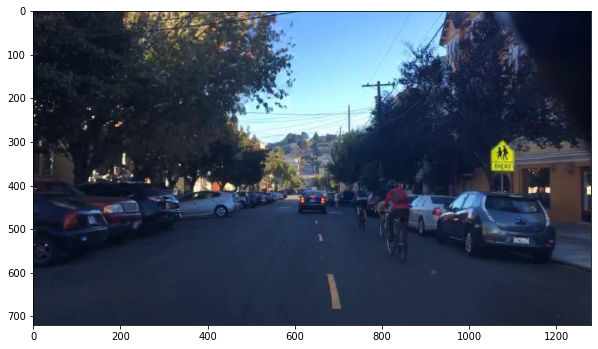

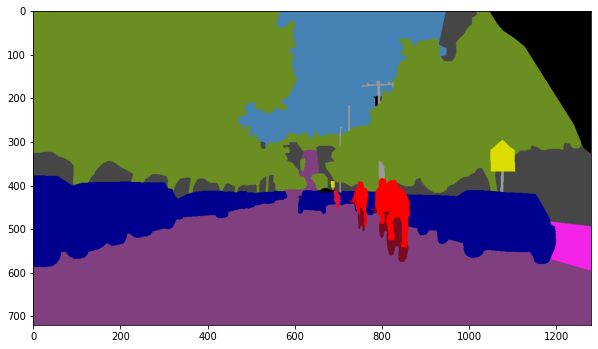

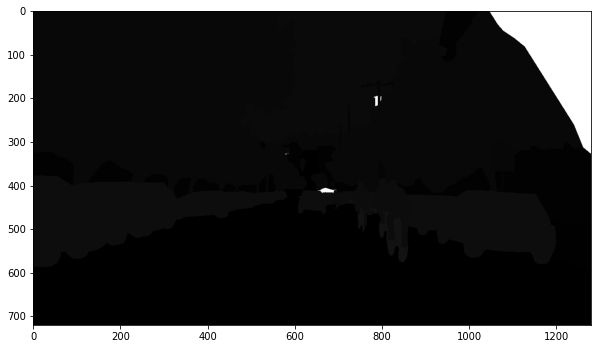

In [20]:
# example showing
# ---------------

ex_img_name = '0d242d07-6298ac79'
ex_col_img_url = base_folder + 'images/train/' + ex_img_name + '.jpg'
ex_labels_url = base_folder + 'labels/train/' + ex_img_name + '_train_id.png'
ex_col_labels_url = base_folder + 'color_labels/train/' + ex_img_name + '_train_color.png'

# reading images
# --------------
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cv2.imread(ex_col_img_url), cv2.COLOR_BGR2RGB))
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cv2.imread(ex_col_labels_url), cv2.COLOR_BGR2RGB))
plt.show()
ex_labels = cv2.imread(ex_labels_url)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(ex_labels, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
# printing unique values in labels where every pixel is classified among one of 19 classes
# we will use this to build target maps
# ----------------------------------------------------------------------------------------

np.unique(ex_labels)

array([  0,   1,   2,   5,   7,   8,  10,  11,  12,  13,  18, 255],
      dtype=uint8)

[  0   1   2   5   7   8  10  11  12  13  18 255]
(300, 300, 3)


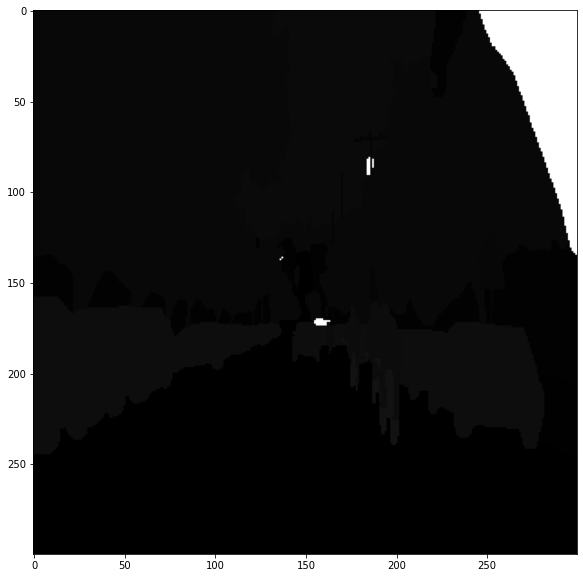

In [22]:
# resize and view - resize with fixed interpolation from CV2
# ----------------------------------------------------------

plt.figure(figsize=(10,10))
im_r = cv2.resize(ex_labels, (300,300), interpolation = cv2.INTER_NEAREST)
print(np.unique(im_r))
print(im_r.shape)
plt.imshow(im_r)

### 2. training data visualisation

In [23]:

# set the number of classes we want to segment (including 0)
# set up h,w
# create traing data
# ----------------------------------------------------------

create_trainset_pool(base_folder, 255, 255, 22, 64, 'train', True)

Done. access at global x_input, x_target, x_labels & x_colormaps.


In [24]:
# global data shapes for ref
# --------------------------
global x_input, x_target, x_colormaps, x_labels
x_input_ex, x_target_ex, x_colormaps_ex, x_labels_ex = x_input, x_target, x_colormaps, x_labels
del x_input, x_target, x_colormaps, x_labels

print(x_input_ex.shape)
print(x_labels_ex.shape)
print(x_target_ex.shape)
print(x_colormaps_ex.shape)

(64, 255, 255, 3)
(64, 255, 255, 3)
(64, 255, 255, 22)
(64, 255, 255, 3)


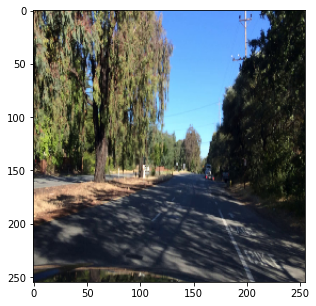

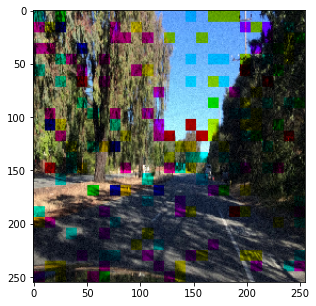

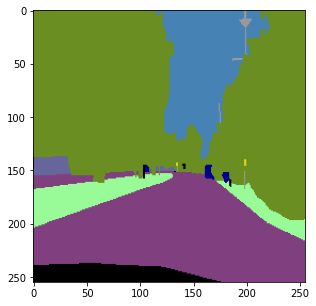

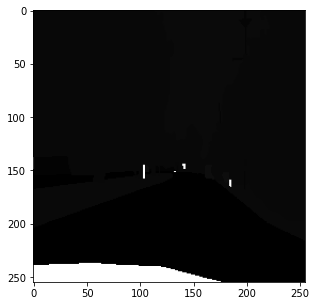

In [25]:
# showing random data
# -------------------
randrange = random.sample(list(range(x_input_ex.shape[0])), 1)

x_ran = x_input_ex[randrange]
x_ran_aug = imgaug_onthego_std(x_ran)
c = 0

for i in randrange:
    plt.figure(figsize=(5,5))
    plt.imshow(x_input_ex[i].astype('uint8'))
    plt.show()
    plt.figure(figsize=(5,5))
    plt.imshow(x_ran_aug[c].astype('uint8'))
    plt.show()
    c += 1
    plt.figure(figsize=(5,5))
    plt.imshow(x_colormaps_ex[i].astype('uint8'))
    plt.show()
    plt.figure(figsize=(5,5))
    plt.imshow(x_labels_ex[i].astype('uint8'))
    plt.show()

### 3. model setup

In [ ]:
# snippet to work out filter sizes
# --------------------------------
f = 3
s = 2
pad = 0
layers = 7

h = 255
w = 255
print('Showing conv down sizes - ')
print('--------------------------')
# showing out sizes after conv
# ----------------------------
for _ in range(layers):   
    h,w = outsize_conv(h,w,f,s,pad)
    print((h,w))
    
h = 1
w = 1
print('\nShowing conv up sizes - ')
print('--------------------------')

# showing out sizes after conv
# ----------------------------
for _ in range(layers):   
    h,w = outsize_upconv(h,w,f,s,pad)
    print((h,w))


### 3.1 model training

In [26]:
# initialising model
# ------------------

model_seg = fcn_UNET_segmentation(x_target_ex.shape[3])
model_seg.apply(weights_init)
print('model created')
model_seg

model created


fcn_UNET_segmentation(
  (cl00): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (cl0): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (cl1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (cl2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (

In [30]:
# training loop
# -------------

# model_train(base_train_url,len_classlabels,load_mode,model,epochs,mbsize,save_state,base_name,path)


# model save path set up
# ----------------------
cn_save_path = base_url + 'code/models/'

# declaring base name
# -------------------
base_name = 'eplane_street_segmentation_22classes_32_22'


# training
# --------
model_seg = model_train(base_folder,x_target_ex.shape[3],'from saved',model_seg,-1,32,True,base_name,cn_save_path)

Loading model from saved state...
Last saved recons loss - 0.009542630985379219
Last saved recons epoch - 7125
**********************
finished setting models up for GPU..


In [31]:
# end of training code
##

### 3.2 inference

orig image - 


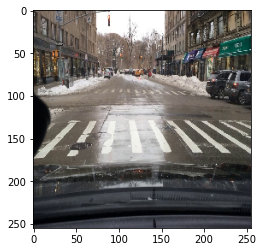

orig overlayed - 


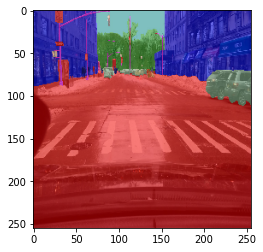

predicted overlayed - 


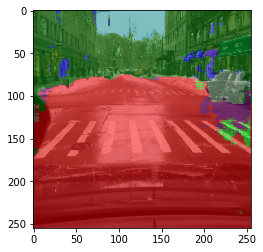

orig image - 


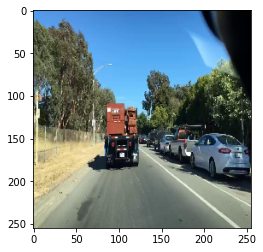

orig overlayed - 


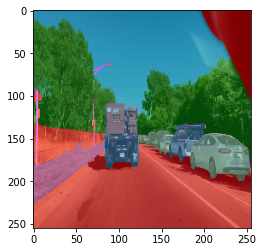

predicted overlayed - 


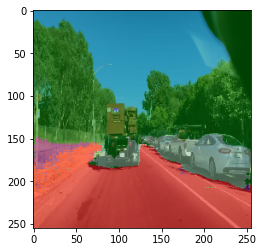

orig image - 


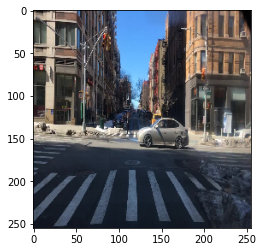

orig overlayed - 


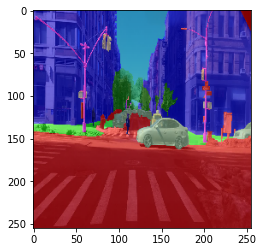

predicted overlayed - 


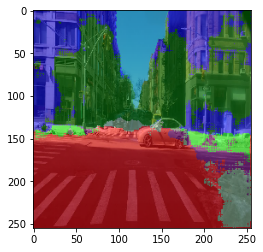

In [34]:
# train set inference
# -------------------
randrange = random.sample(list(range(x_input_ex.shape[0])), 3)

# orig inputs
# -----------
x_input_train_inf = x_input_ex[randrange]
x_target_train_inf = x_target_ex[randrange]
x_colormaps_train_inf = return_colormap(x_target_train_inf)


# model out
# ---------
x_target_model_out = model_seg.cpu().eval()(Variable(setup_image_tensor(x_input_train_inf)).float()/np.max(x_input_train_inf))
x_target_model_out_colormap = return_colormap(to_numpy_image(x_target_model_out))

# plotting
# ---------
for i in range(x_input_train_inf.shape[0]):
    
    print('orig image - ')
    plt.imshow(x_input_train_inf[i].astype('uint8'))
    plt.show()
    
    #print('orig color map - ')
    #plt.imshow(x_colormaps_train_inf[i].astype('uint8'))
    #plt.show()
    
    #print('predicted color map - ')
    #plt.imshow(x_target_model_out_colormap[i].astype('uint8'))
    #plt.show()
    
    # overlayed - 
    # ----------
    print('orig overlayed - ')
    overlayed = x_input_train_inf[i] * 0.5 + x_colormaps_train_inf[i] * 0.5
    plt.imshow(overlayed.astype('uint8'))
    plt.show()
    
    # overlayed - 
    # ----------
    print('predicted overlayed - ')
    overlayed = x_input_train_inf[i] * 0.5 + x_target_model_out_colormap[i] * 0.5
    plt.imshow(overlayed.astype('uint8'))
    plt.show()
    

In [ ]:
# end of inference
#

### 3.3 accuracy class wise

In [35]:
# printing accuracy metrics
# -------------------------

precision_recall_f1_accuracy(to_numpy_image(x_target_model_out), x_target_train_inf,0.5)

Basic accuracy: 0.9749126792725408

Precision, recall and f1 scores: 
********************************

Label: 0
------------
Precision: 0.78
Recall: 0.82
F1 Score: 0.8


Label: 1
------------
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


Label: 2
------------
Precision: 0.94
Recall: 0.16
F1 Score: 0.28


Label: 3
------------
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


Label: 4
------------
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


Label: 5
------------
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


Label: 6
------------
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


Label: 7
------------
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


Label: 8
------------
Precision: 0.43
Recall: 0.94
F1 Score: 0.59


Label: 9
------------
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


Label: 10
------------
Precision: 0.96
Recall: 0.99
F1 Score: 0.97


Label: 11
------------
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


Label: 12
------------
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


Label: 13
------------
Precision: 0.5

In [ ]:
# end of this
# 

# rough